In [1]:
from __future__ import division, print_function

import netCDF4 as nc
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import glob
from geopy.distance import vincenty
from exceptions import KeyError
import gsw
%matplotlib inline

In [2]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')

In [3]:
mask = mesh.variables['tmask'][0,:,:,:]

In [4]:
coordhgr = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_mesh_hgr.nc')
coordzgr = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_mesh_zgr.nc')
mesh = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/mesh_mask_anha4_201509.nc')
grid = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')

In [5]:
e1v = mesh.variables['e1v'][0,:,:]
e3v = mesh.variables['e3v'][0,:,:,:]
e2u = mesh.variables['e2u'][0,:,:]
e3u = mesh.variables['e3u'][0,:,:,:]
e1t= mesh.variables['e1t'][0,400:,:]  # dx
e2t= mesh.variables['e2t'][0,400:,:]  # dy 
e3t= mesh.variables['e3t'][0,:,400:,:]
tmask= mesh.variables['tmask'][0,:,400:,:]
dep = mesh.variables['gdept_0'][0,:]

In [6]:
H = coordzgr.variables['nav_lev']
bathy = grid.variables['Bathymetry'][:]
lat = np.array(grid.variables['nav_lat'])
lon = np.array(grid.variables['nav_lon'])
bathy = ma.masked_values(bathy[:],0)

In [7]:
control = '/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_'
stlandj = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/ANHA4-VJT002_'
polzin  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/ANHA4-VJT003_'

In [8]:
#put in the coordinates for the individual areas of study
#Kara and Barenst Sea Corners
lats = lat
lons = lon
kbsc_lat = [lats[475,325],lats[675,325],lats[675,500],lats[475,500],lats[475,325]]
kbsc_lon = [lons[475,325],lons[675,325],lons[675,500],lons[475,500],lons[475,325]]

esls_lat = [lats[650,200],lats[799,200],lats[799,415],lats[650,415],lats[650,200]]
esls_lon = [lons[650,200],lons[799,200],lons[799,415],lons[650,415],lons[650,200]]

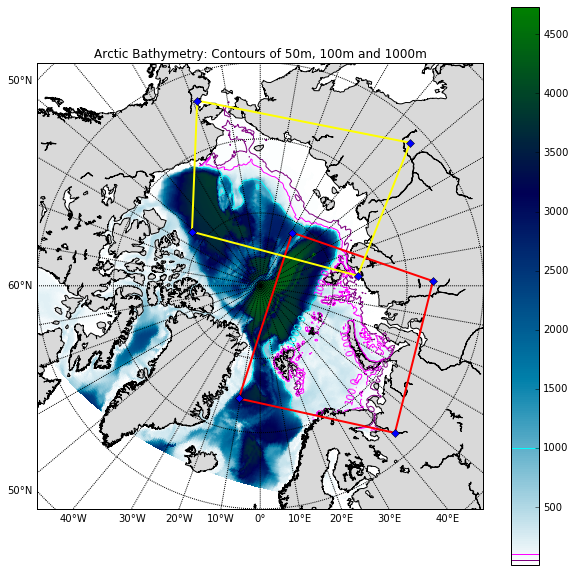

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=False)
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,90.,10.),labels=[1, 0, 0, 0],latmax=90)
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0, 0, 0, 1],latmax=90)
cmap = plt.get_cmap('ocean_r')
x_lons, y_lats = m(lon, lat)
maps = m.pcolor(x_lons[400:-1,:], y_lats[400:-1,:], bathy[400:-1,:],cmap=cmap)

cbar = plt.colorbar(maps)

clines = m.contour(x_lons[475:675,325:500], y_lats[475:675,325:500], bathy[475:675,325:500],np.array([50,100,1000]),colors=['purple','fuchsia','cyan'])
clines2 = m.contour(x_lons[650:800,200:415], y_lats[650:800,200:415], bathy[650:800,200:415],np.array([50,100,1000]),colors=['purple','fuchsia','cyan'])
ax.clabel(clines, fmt='%1.1f')
# cbar = plt.colorbar(clines)
cbar.add_lines(clines) 


x, y = m(kbsc_lon, kbsc_lat) # forgot this line
m.plot(x, y, 'D-', markersize=5, linewidth=2, color='red', markerfacecolor='b') 


x2, y2 = m(esls_lon, esls_lat) # forgot this line
m.plot(x2, y2, 'D-', markersize=5, linewidth=2, color='yellow', markerfacecolor='b') 

plt.title('Arctic Bathymetry: Contours of 50m, 100m and 1000m')
plt.show()

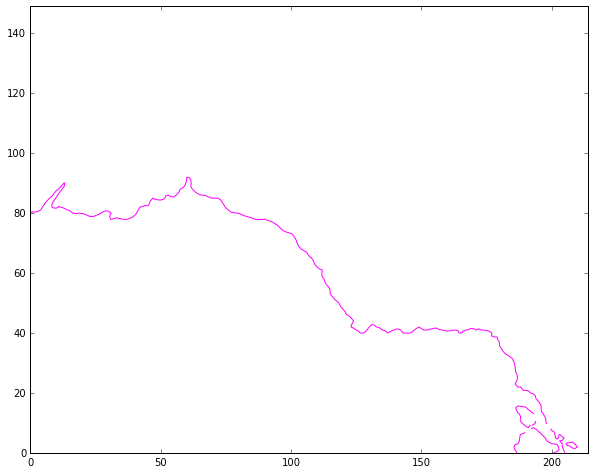

In [10]:
#create function for calculating the flux along a bathymetry contour
#want the grid cells on either side of the bathy line
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
clines = ax.contour( bathy[650:800,200:415],np.array([100]),colors=['fuchsia'])

In [11]:
#get the coordinates for the longest(ie most connected) segment in the contour line above
p = clines.collections[0].get_paths()[4]
v = p.vertices
x = v[:,0]+200
y = v[:,1]+650
#get endpoints
x_end = [int(x[0]),int(x[-1])]
y_end = [int(round(y[0])),round(int(y[-1]))]
#print(x_end,y_end)
x1 = np.around(x)
y1 = np.around(y)

In [12]:
# Algorithm will have two major components
# 1. R represents the isobath where Ri = delta x and Rj = delta y 
# of the first and second points of the isobath
# 2. U represents the zonal and meridional velocities where Ux is u velocity 
#and Uy is v velocity

def annual_trans(bathylinex,bathyliney, lat, lon, year, month=None):
    
   
    if month == None:
        nc_fileU=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m??d??_gridU.nc'))
        nc_fileV=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m??d??_gridV.nc'))
        nc_fileT=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m??d??_gridT.nc'))
    else:
        nc_fileU=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m'+month+'d??_gridU.nc'))
        nc_fileV=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m'+month+'d??_gridV.nc'))
        nc_fileT=sorted(glob.glob('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y'+year+'m'+month+'d??_gridT.nc')) 
    
    U_pout = 0.0
    U_a = 0.0
    U_p = 0.0
    density_avg = np.zeros((50,len(bathylinex)-1))
    
    for filenum in range(0,len(nc_fileU)-1):
        print(filenum)
        zonalvel = nc.Dataset(nc_fileU[filenum]).variables['vozocrtx'][0,:,:,:]
        meridvel = nc.Dataset(nc_fileV[filenum]).variables['vomecrty'][0,:,:,:]
        sal = nc.Dataset(nc_fileT[filenum]).variables['vosaline'][0,:,:,:]
        temp = nc.Dataset(nc_fileT[filenum]).variables['votemper'][0,:,:,:]
    
        uflux = np.zeros_like(zonalvel)
        vflux = np.zeros_like(meridvel)
        
        for k in np.arange(0,50):
            uflux[k,:,:] = zonalvel[k,:,:]*e2u*e3u[k,:,:]
            vflux[k,:,:] = meridvel[k,:,:]*e1v*e3v[k,:,:]
        
        U_anew, U_pnew, density = bathy_trans(y,x,uflux,vflux,sal,temp,lat,lon)
        U_asum = np.sum(U_anew)
        U_psum = np.sum(U_pnew)
        U_a = U_a + U_asum*(10**(-6))
        U_p = U_p + U_psum*(10**(-6))
        density_avg = density_avg + density
        
        if U_psum<0.0:
            U_pout = U_pout + abs(U_psum)
    density_avg = density_avg/len(nc_fileT)
        
    return U_a, U_p, U_pout, density_avg

def bathy_trans(bathylinex,bathyliney, u, v, sal, temp, lat, lon):
    '''
    bathyline should be an array with a series of x,y pairs indicating the location of the isobath
    bathy, ux and uy are the full domain matrices of bathymetry, u velocity and v velocity respectively
    '''
    U_along = np.zeros((50,len(bathylinex)-1))
    U_perp = np.zeros((50,len(bathylinex)-1))
    density = np.zeros((50,len(bathylinex)-1))
    
    for kk in np.arange(0,len(bathylinex)-1):
        #Ri is the distance in x grid direction
        #Rj is distance in y grid direction
        Ri = vincenty((lat[bathylinex[kk],bathyliney[kk]],lon[bathylinex[kk],bathyliney[kk]]),
                     (lat[bathylinex[kk+1],bathyliney[kk]],lon[bathylinex[kk+1],bathyliney[kk]])).meters
    
        Rj = vincenty((lat[bathylinex[kk],bathyliney[kk]],lon[bathylinex[kk],bathyliney[kk]]),
                     (lat[bathylinex[kk],bathyliney[kk+1]],lon[bathylinex[kk],bathyliney[kk+1]])).meters
        
        Ux = u[:,bathylinex[kk],bathyliney[kk]]
        Uy = v[:,bathylinex[kk],bathyliney[kk]]
        #calc along bathy line vector components
        Ux_along = (Ri*(np.dot(Ri,Ux[:])+np.dot(Rj,Uy[:])))/(Ri**2+Rj**2)
        Uy_along = (Rj*(np.dot(Ri,Ux[:])+np.dot(Rj,Uy[:])))/(Ri**2+Rj**2)
        #calculate along shore vector
        J = np.sqrt(Ux_along**2+Uy_along**2)
        U_along[:,kk] = J[:]
        #Calculate across bathy line vector components
        Ux_perp = Ux-Ux_along
        Uy_perp = Uy-Uy_along
        #Calcluate across bathy vector
        I = np.sqrt(Ux_perp**2+Uy_perp**2)
        U_perp[:,kk] = I[:]
        density[:,kk] = density_flux(temp[:,bathylinex[kk],bathyliney[kk]],sal[:,bathylinex[kk],bathyliney[kk]],
                                     lat[bathylinex[kk],bathyliney[kk]])
        
    return U_along, U_perp, density

def density_flux(temp, sal,lat ):
    '''
    Calculates potential density anomoly
    '''
    p = np.zeros_like(sal,dtype=np.dtype('f8'))

    for depth in np.arange(0,len(dep)):
        p[depth] = gsw.p_from_z(dep[depth],lat)
    density = gsw.sigma0(sal,temp)
    return density

## Siberian Shelf Fluxes

In [13]:
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
y2010 = []
y2011 = []
y2012 = []
y2013 = []
y2014 = []
y2015 = []
density = []
for i in range(0,2):
    U_a, U_p, U_pout,density_avg = annual_trans(y,x,lat,lon,'2010',months[i])
    y2010.append(U_p)
    density.append(density_avg)
    print(i)
#     U_a,U_p, U_pout, density = annual_trans(y,x,lat,lon,'2011',months[i])
#     y2011.append(U_p)
#     U_a, U_p, U_pout,density = annual_trans(y,x,lat,lon,'2012',months[i])
#     y2012.append(U_p)
#     U_a, U_p, U_pout,density = annual_trans(y,x,lat,lon,'2013',months[i])
#     y2013.append(U_p)
#     U_a, U_p, U_pout,density = annual_trans(y,x,lat,lon,'2014',months[i])
#     y2014.append(U_p)
#     U_a, U_p, U_pout,density = annual_trans(y,x,lat,lon,'2015',months[i])
#     y2015.append(U_p)
    

0


/home/jacquielee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jacquielee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jacquielee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:66: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jacquielee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:67: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jacquielee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jacquielee/anaconda2/lib/python2.7/site-packages/ipyke

1
2
3
4
0
0
1
2
3
1


In [50]:
print(density)

[[  20.39669894   20.29660112   20.26146242 ...,   20.18591479
    20.14886916   20.10323393]
 [  20.39697905   20.2966005    20.26146242 ...,   20.18593965
    20.14890868   20.10327701]
 [  20.39901649   20.2966005    20.26146211 ...,   20.18598271
    20.14897179   20.10333761]
 ..., 
 [ 799.8736718   799.8736718   799.8736718  ...,  799.8736718   799.8736718
   799.8736718 ]
 [ 799.8736718   799.8736718   799.8736718  ...,  799.8736718   799.8736718
   799.8736718 ]
 [ 799.8736718   799.8736718   799.8736718  ...,  799.8736718   799.8736718
   799.8736718 ]]


In [52]:
#U_a = np.ma.masked_where(U_a[:,:]==0, U_a)
m = np.arange(0,337)
n = H[:22]
X, Y = np.meshgrid(m[:], n[:])

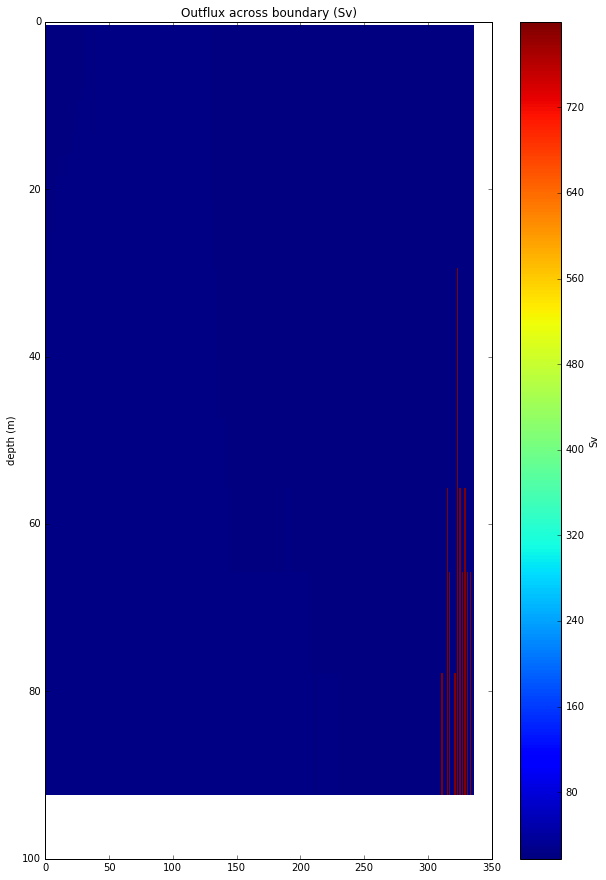

In [54]:
fig, axes = plt.subplots(1,1, figsize = (10,15))
mesh = axes.pcolor(X,Y,density[:22,:])
axes.set_ylim(axes.get_ylim()[::-1])
cbar = fig.colorbar(mesh,ax=axes,label='Sv')
#plt.plot(date_list,EXH005['Bo'],label='Barents Sea')
axes.set_ylabel('depth (m)')
axes.set_title('Outflux across boundary (Sv)')

In [76]:
#nc.Dataset('/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_y2002m01d05_gridT.nc').variables